# Latent Dirichlet Allocation (LDA) 구현

## 개요
LDA(Latent Dirichlet Allocation)는 문서 집합의 추상적인 주제를 발견하기 위한 확률적 토픽 모델링 기법입니다. 각 문서를 여러 토픽의 혼합으로, 각 토픽을 여러 단어의 혼합으로 표현하는 것이 핵심입니다.

## 데이터셋: BBC News
- 5개 카테고리의 뉴스 기사 (business, entertainment, politics, sport, tech)
- 약 2,225개의 문서
- 각 문서는 전문 기자가 작성한 영문 뉴스 기사

## LDA 작동 원리

### 1. 문서-단어 행렬 생성
- 각 문서를 단어의 빈도로 표현 (Bag of Words)
- 행: 문서, 열: 단어
- 각 셀: 해당 단어의 등장 빈도

### 2. 생성 과정 모델링
문서 생성 과정을 확률적으로 모델링:
1. 각 문서의 토픽 분포 ~ Dirichlet(α)
2. 각 토픽의 단어 분포 ~ Dirichlet(β)
3. 각 단어의 토픽 할당 ~ Multinomial(θ)

### 3. 추론
- Gibbs Sampling 등의 방법으로 잠재 변수 추정
- 문서별 토픽 분포와 토픽별 단어 분포 학습
- 반복적인 샘플링으로 최적 분포 탐색

### 4. 토픽 공간
학습된 모델에서:
- 각 문서는 토픽 분포로 표현
- 각 토픽은 단어 분포로 표현
- 문서와 단어의 관계를 확률적으로 해석

## LDA의 장점
1. 해석 가능성
   - 각 토픽이 단어들의 확률 분포로 표현되어 직관적
2. 유연성
   - 문서가 여러 토픽을 가질 수 있음
3. 확률적 접근
   - 불확실성을 명시적으로 모델링

## LDA의 한계
1. 토픽 수 설정
   - 최적의 토픽 수를 사전에 지정해야 함
2. 계산 복잡도
   - 대규모 문서에서 추론 시간이 오래 걸림
3. 토픽 일관성
   - 때때로 의미적으로 일관성 없는 토픽이 생성될 수 있음

## LDA(Latent Dirichlet Allocation) 활용 방안

### 1. 토픽 분석
- 문서 컬렉션의 주요 주제 자동 발견
- 시간에 따른 토픽 트렌드 분석
- 토픽 간 관계 및 계층 구조 파악

### 2. 문서 분류/추천
- 토픽 기반 문서 분류
- 유사 문서 추천
- 사용자 관심 토픽 기반 개인화 추천

### 3. 콘텐츠 분석
- 뉴스 기사 토픽 모니터링
- 소셜 미디어 트렌드 분석
- 학술 논문 연구 동향 파악

### 4. 비즈니스 인사이트
- 고객 리뷰/피드백 분석
- 시장 트렌드 예측
- 경쟁사 동향 모니터링
- 제품/서비스 개선점 발견

# LSI vs LDA 비교

## 1. 기본 접근 방식
### LSI: "수학적 분해"
- 선형 대수 기반 (SVD 사용)
- 문서-단어 행렬을 분해하여 패턴 발견
- 결정론적(deterministic) 방법
- 예시: 문서 = (0.8 × 스포츠_패턴) + (-0.2 × 정치_패턴)

### LDA: "확률적 생성"
- 베이지안 추론 기반
- 문서 생성 과정을 확률적으로 모델링
- 각 단어의 토픽 소속을 추적
- 예시: 문서 = (60% 스포츠_토픽) + (40% 정치_토픽)

## 2. 주요 특징 비교
### 해석 방식
- LSI: 추상적인 벡터 공간, 음수 값 존재
- LDA: 직관적인 확률 분포 (0~100%)

### 성능
- LSI: 빠른 계산, 작은 데이터셋에 적합
- LDA: 느린 계산, 큰 데이터셋에서 강점

### 확장성
- LSI: 새 문서 추가시 전체 재계산 필요
- LDA: 새 문서에 대한 개별 추론 가능

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from zipfile import ZipFile
from io import BytesIO

# NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('stopwords')

# BBC News 데이터셋 다운로드 함수
def download_bbc_dataset():
    # 데이터셋 URL
    url = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
    
    # 데이터를 저장할 디렉토리 생성
    if not os.path.exists('bbc'):
        print("Downloading BBC dataset...")
        response = requests.get(url)
        with ZipFile(BytesIO(response.content)) as zip_file:
            zip_file.extractall()
        print("Download completed!")
    else:
        print("Dataset already exists!")

# 데이터 로드 함수
def load_bbc_data():
    categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
    texts = []
    labels = []
    
    for category in categories:
        path = f'bbc/{category}'
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(category)
    
    return pd.DataFrame({'text': texts, 'category': labels})

# 데이터셋 다운로드 및 로드
download_bbc_dataset()
df = load_bbc_data()

# 기본 데이터 정보 출력
print("\nDataset Info:")
print(f"Total number of documents: {len(df)}")
print("\nDocuments per category:")
print(df['category'].value_counts())

# 첫 번째 문서 일부 출력
print("\nFirst document preview:")
print(df['text'].iloc[0][:500])

Dataset already exists!

Dataset Info:
Total number of documents: 2225

Documents per category:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

First document preview:
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time W


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 전처리

In [4]:
# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# # 필요한 모든 NLTK 데이터 다운로드
# try:
#     nltk.download('all')  # 모든 NLTK 데이터 다운로드
#     print("모든 NLTK 데이터 다운로드 완료!")
# except Exception as e:
#     print(f"다운로드 중 오류 발생: {e}")

# # 테스트
# try:
#     from nltk.corpus import stopwords
#     from nltk.tokenize import word_tokenize, sent_tokenize
    
#     # 간단한 테스트
#     test_text = "This is a test sentence. This is another sentence."
#     sentences = sent_tokenize(test_text)
#     tokens = word_tokenize(test_text)
    
#     print("\n테스트 성공!")
#     print(f"문장 분리: {sentences}")
#     print(f"토큰화: {tokens}")
# except Exception as e:
#     print(f"테스트 중 오류 발생: {e}")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipp

모든 NLTK 데이터 다운로드 완료!

테스트 성공!
문장 분리: ['This is a test sentence.', 'This is another sentence.']
토큰화: ['This', 'is', 'a', 'test', 'sentence', '.', 'This', 'is', 'another', 'sentence', '.']


[nltk_data]    |   Unzipping corpora\ycoe.zip.
[nltk_data]    | 
[nltk_data]  Done downloading collection all


In [15]:
def preprocess_text(text):
    """
    텍스트 전처리 개선 버전
    """
    # 토큰화
    tokens = word_tokenize(text.lower())
    
    # 불용어 및 특수문자 제거
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if (
        token.isalpha() and  # 알파벳으로만 이루어진 단어
        len(token) > 2 and   # 3글자 이상
        token not in stop_words  # 불용어가 아님
    )]
    
    return ' '.join(tokens)

# BoW 벡터화 파라미터 수정
vectorizer = CountVectorizer(
    max_features=5000,  # 최대 단어 수
    min_df=5,          # 최소 5개 문서에서 등장
    max_df=0.95,       # 전체 문서의 95% 이하에서 등장
    token_pattern=r'(?u)\b[a-zA-Z]+\b'  # 알파벳으로만 이루어진 단어
)

# 전처리 적용
df['processed_text'] = df['text'].apply(preprocess_text)
bow_matrix = vectorizer.fit_transform(df['processed_text'])

# LDA(Latent Dirichlet Allocation) 학습 과정

## 1. 전처리 단계
### 데이터 정제
- 텍스트 소문자화
- 불용어(stopwords) 제거
- 특수문자 제거
- 토큰화(단어 분리)

### BoW(Bag of Words) 생성
- 문서-단어 행렬 생성
- 각 문서별 단어 출현 빈도 계산
- 너무 희귀하거나 흔한 단어 제거

## 2. 초기화 단계
### 하이퍼파라미터 설정
- 토픽 수(K) 지정
- α: 문서-토픽 분포의 집중도
- β: 토픽-단어 분포의 집중도

### 초기 랜덤 할당
- 각 단어에 무작위로 토픽 할당
- 문서-토픽 카운트 테이블 생성
- 토픽-단어 카운트 테이블 생성

## 3. 반복 학습 단계 (깁스 샘플링)
### 각 단어마다 반복
1. 현재 할당된 토픽의 카운트 제거
   - 문서-토픽 카운트 감소
   - 토픽-단어 카운트 감소

2. 새로운 토픽 선택
   - 문서의 토픽 분포 고려
   - 각 토픽의 단어 분포 고려
   - 두 확률을 곱해서 새 토픽 샘플링

3. 새 토픽으로 카운트 업데이트
   - 문서-토픽 카운트 증가
   - 토픽-단어 카운트 증가

### 수렴 조건
- 정해진 반복 횟수 도달
- 또는 분포의 변화가 미미할 때

## 4. 최종 확률 분포 계산
### 토픽-단어 분포 (φ)
- 각 토픽별 단어 카운트 + β
- 정규화하여 확률 분포로 변환

### 문서-토픽 분포 (θ)
- 각 문서별 토픽 카운트 + α
- 정규화하여 확률 분포로 변환

## 5. 결과 해석
### 토픽 해석
- 각 토픽의 주요 단어들 확인
- 단어 확률 분포 기반 토픽 의미 파악

### 문서 분류
- 각 문서의 토픽 비율 확인
- 주요 토픽 기반 문서 특성 파악

## 주요 특징
- 비지도 학습: 레이블 없이 학습
- 소프트 클러스터링: 문서가 여러 토픽을 가질 수 있음
- 확률적 모델: 불확실성을 명시적으로 모델링
- 해석 가능성: 결과가 직관적으로 해석 가능

In [16]:
def initialize_topics(bow_matrix, n_topics):
    """
    이미 전처리된 BoW 행렬에서 초기 토픽을 랜덤하게 할당
    """
    n_docs, n_vocab = bow_matrix.shape
    
    # 카운트 행렬 초기화
    doc_topic_counts = np.zeros((n_docs, n_topics), dtype=int)
    topic_word_counts = np.zeros((n_topics, n_vocab), dtype=int)
    topic_assignments = []
    
    # 각 문서의 각 단어에 대해 토픽 무작위 할당
    for doc_idx in range(n_docs):
        current_doc_topics = []
        for word_idx in range(n_vocab):
            word_count = bow_matrix[doc_idx, word_idx]
            
            if word_count > 0:
                doc_word_topics = []
                for _ in range(word_count):
                    topic = np.random.randint(0, n_topics)
                    doc_word_topics.append(topic)
                    doc_topic_counts[doc_idx, topic] += 1
                    topic_word_counts[topic, word_idx] += 1
                current_doc_topics.append(doc_word_topics)
            else:
                current_doc_topics.append([])
        topic_assignments.append(current_doc_topics)
    
    return doc_topic_counts, topic_word_counts, topic_assignments

# 테스트
n_topics = 20  # BBC 뉴스의 토픽 수를 20개로 설정
doc_topic_counts, topic_word_counts, topic_assignments = initialize_topics(bow_matrix, n_topics)

print("문서-토픽 카운트 행렬 크기:", doc_topic_counts.shape)
print("토픽-단어 카운트 행렬 크기:", topic_word_counts.shape)

문서-토픽 카운트 행렬 크기: (2225, 20)
토픽-단어 카운트 행렬 크기: (20, 5000)


In [17]:
def gibbs_sampling(bow_matrix, n_topics, n_iterations, alpha, beta):
    """
    LDA 깁스 샘플링 수행
    
    Parameters:
    -----------
    bow_matrix : scipy.sparse.csr_matrix
        문서-단어 행렬
    n_topics : int
        토픽 수
    n_iterations : int
        반복 횟수
    alpha : float
        문서-토픽 디리클레 파라미터
    beta : float
        토픽-단어 디리클레 파라미터
    
    Returns:
    --------
    doc_topic_dist : numpy.ndarray
        최종 문서-토픽 분포
    topic_word_dist : numpy.ndarray
        최종 토픽-단어 분포
    """
    n_docs, n_vocab = bow_matrix.shape
    
    # 초기 토픽 할당
    doc_topic_counts, topic_word_counts, topic_assignments = initialize_topics(bow_matrix, n_topics)
    
    # 전체 토픽별 단어 수
    topic_totals = topic_word_counts.sum(axis=1)
    
    # 깁스 샘플링 반복
    for iteration in range(n_iterations):
        for doc_idx in range(n_docs):
            for word_idx in range(n_vocab):
                word_count = bow_matrix[doc_idx, word_idx]
                
                if word_count > 0:
                    # 현재 단어의 토픽들
                    old_topics = topic_assignments[doc_idx][word_idx]
                    
                    for i, old_topic in enumerate(old_topics):
                        # 현재 할당 제거
                        doc_topic_counts[doc_idx, old_topic] -= 1
                        topic_word_counts[old_topic, word_idx] -= 1
                        topic_totals[old_topic] -= 1
                        
                        # 새로운 토픽 샘플링
                        p_topic = (doc_topic_counts[doc_idx] + alpha) * \
                                (topic_word_counts[:, word_idx] + beta) / \
                                (topic_totals + beta * n_vocab)
                        
                        # 정규화
                        p_topic = p_topic / p_topic.sum()
                        
                        # 새로운 토픽 선택
                        new_topic = np.random.choice(n_topics, p=p_topic)
                        
                        # 새로운 토픽으로 업데이트
                        old_topics[i] = new_topic
                        doc_topic_counts[doc_idx, new_topic] += 1
                        topic_word_counts[new_topic, word_idx] += 1
                        topic_totals[new_topic] += 1
        
        if (iteration + 1) % 5 == 0:
            print(f"Iteration {iteration + 1} completed")
    
    # 최종 분포 계산
    doc_topic_dist = (doc_topic_counts + alpha) / \
                    (doc_topic_counts.sum(axis=1)[:, np.newaxis] + n_topics * alpha)
    topic_word_dist = (topic_word_counts + beta) / \
                     (topic_word_counts.sum(axis=1)[:, np.newaxis] + n_vocab * beta)
    
    return doc_topic_dist, topic_word_dist

# 테스트
n_topics = 20
n_iterations = 50
alpha = 0.1
beta = 0.1

doc_topic_dist, topic_word_dist = gibbs_sampling(bow_matrix, n_topics, n_iterations, alpha, beta)

print("\n문서-토픽 분포 크기:", doc_topic_dist.shape)
print("토픽-단어 분포 크기:", topic_word_dist.shape)

Iteration 5 completed


KeyboardInterrupt: 

Top words per topic:

Topic 1:
11: 0.167
10th: 0.167
10bn: 0.167
100m: 0.167
100: 0.167
10: 0.167

Topic 2:
11: 0.167
10th: 0.167
10bn: 0.167
100m: 0.167
100: 0.167
10: 0.167

Topic 3:
10bn: 0.583
11: 0.306
10th: 0.028
100m: 0.028
100: 0.028
10: 0.028

Topic 4:
10: 0.688
11: 0.062
10th: 0.062
10bn: 0.062
100m: 0.062
100: 0.062

Topic 5:
100m: 0.423
10: 0.423
11: 0.038
10th: 0.038
10bn: 0.038
100: 0.038

Topic 6:
100m: 0.423
100: 0.423
11: 0.038
10th: 0.038
10bn: 0.038
10: 0.038

Topic 7:
11: 0.167
10th: 0.167
10bn: 0.167
100m: 0.167
100: 0.167
10: 0.167

Topic 8:
11: 0.167
10th: 0.167
10bn: 0.167
100m: 0.167
100: 0.167
10: 0.167

Topic 9:
10th: 0.688
11: 0.062
10bn: 0.062
100m: 0.062
100: 0.062
10: 0.062

Topic 10:
10th: 0.688
11: 0.062
10bn: 0.062
100m: 0.062
100: 0.062
10: 0.062

Topic 11:
11: 0.167
10th: 0.167
10bn: 0.167
100m: 0.167
100: 0.167
10: 0.167

Topic 12:
11: 0.167
10th: 0.167
10bn: 0.167
100m: 0.167
100: 0.167
10: 0.167

Topic 13:
10: 0.688
11: 0.062
10th: 0.062
10bn: 0.0

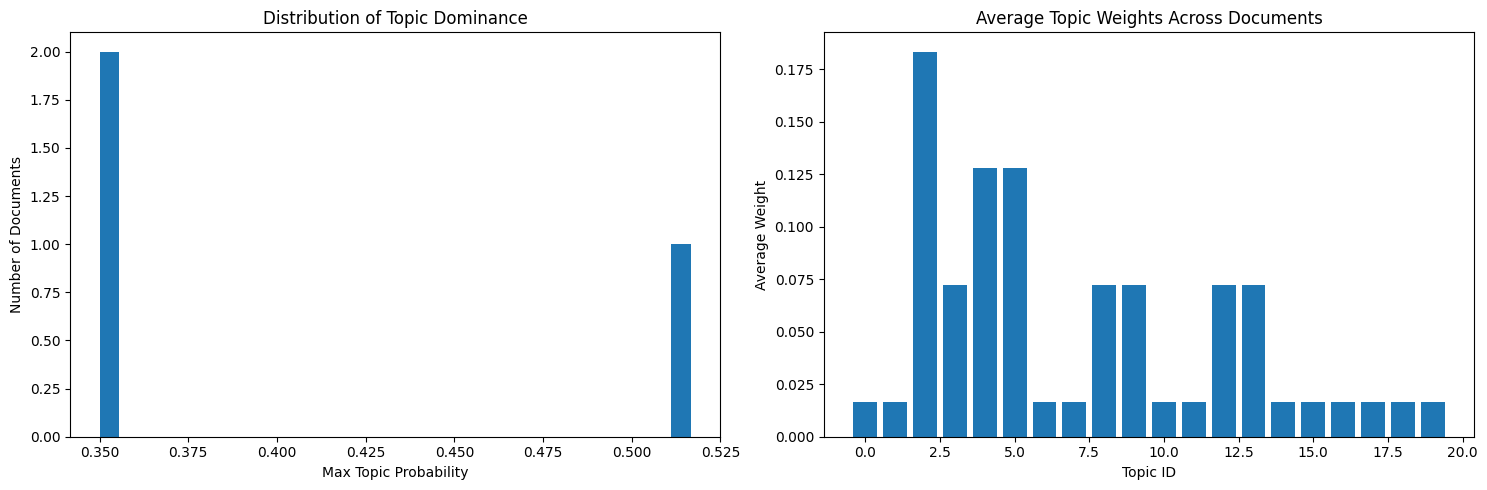

c:\Users\dongi\anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\dongi\anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


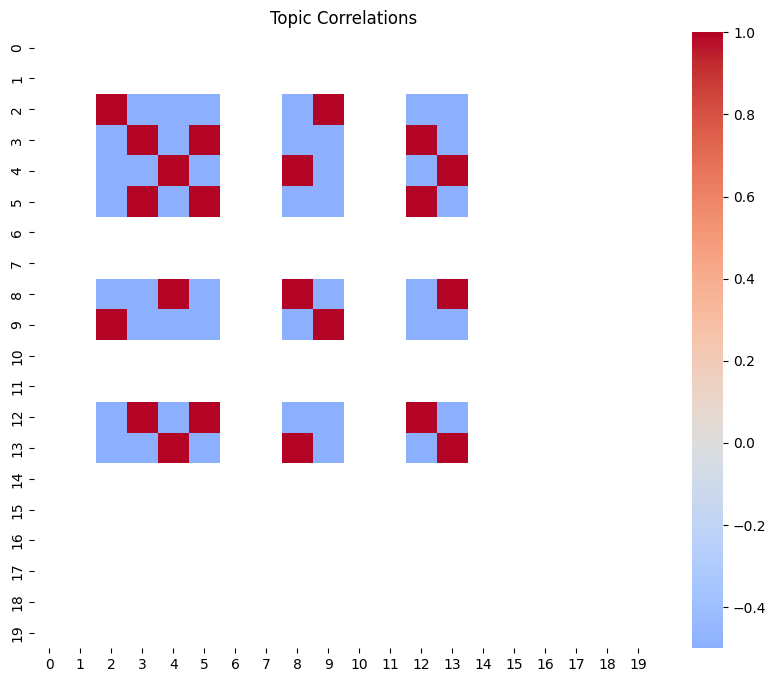


Document-Topic Distribution (top 3 topics per document):

Document 1:
Topic 6: 0.350
Topic 4: 0.183
Topic 13: 0.183

Document 2:
Topic 3: 0.517
Topic 10: 0.183
Topic 19: 0.017

Document 3:
Topic 5: 0.350
Topic 9: 0.183
Topic 14: 0.183


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def print_top_words(topic_word_dist, feature_names, n_top_words=10):
    """
    각 토픽별 상위 단어들을 출력
    """
    for topic_idx, topic_dist in enumerate(topic_word_dist):
        top_words_idx = topic_dist.argsort()[:-n_top_words-1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        top_probs = topic_dist[top_words_idx]
        
        print(f"\nTopic {topic_idx + 1}:")
        for word, prob in zip(top_words, top_probs):
            print(f"{word}: {prob:.3f}")

def visualize_topics(doc_topic_dist, topic_word_dist):
    """
    토픽 모델링 결과 시각화
    """
    plt.figure(figsize=(15, 5))
    
    # 1. 문서별 주요 토픽 분포
    plt.subplot(1, 2, 1)
    plt.hist(doc_topic_dist.max(axis=1), bins=30)
    plt.title('Distribution of Topic Dominance')
    plt.xlabel('Max Topic Probability')
    plt.ylabel('Number of Documents')
    
    # 2. 평균 토픽 분포
    plt.subplot(1, 2, 2)
    topic_weights = doc_topic_dist.mean(axis=0)
    plt.bar(range(len(topic_weights)), topic_weights)
    plt.title('Average Topic Weights Across Documents')
    plt.xlabel('Topic ID')
    plt.ylabel('Average Weight')
    
    plt.tight_layout()
    plt.show()
    
    # 3. 토픽-토픽 상관관계
    plt.figure(figsize=(10, 8))
    topic_correlations = np.corrcoef(doc_topic_dist.T)
    sns.heatmap(topic_correlations, cmap='coolwarm', center=0)
    plt.title('Topic Correlations')
    plt.show()

# 결과 확인
print("Top words per topic:")
print_top_words(topic_word_dist, vectorizer.get_feature_names_out())

print("\nVisualizing results:")
visualize_topics(doc_topic_dist, topic_word_dist)

# 문서별 주요 토픽 확인
def print_document_topics(doc_topic_dist, n_top_topics=3):
    """
    각 문서의 주요 토픽 출력
    """
    print("\nDocument-Topic Distribution (top 3 topics per document):")
    for doc_idx, doc_dist in enumerate(doc_topic_dist[:5]):  # 처음 5개 문서만
        top_topics = doc_dist.argsort()[:-n_top_topics-1:-1]
        print(f"\nDocument {doc_idx + 1}:")
        for topic_idx in top_topics:
            print(f"Topic {topic_idx + 1}: {doc_dist[topic_idx]:.3f}")

print_document_topics(doc_topic_dist)

In [7]:
# LDA 모델 학습
n_topics = 20  # 토픽 수 지정
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch',
    max_iter=20,
    learning_offset=50.
)

# 모델 학습
doc_topics = lda.fit_transform(bow_matrix)

# 단어 특성 추출
feature_names = vectorizer.get_feature_names_out()

# 토픽별 주요 단어 출력 함수
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        print(f"Topic {topic_idx + 1}:")
        print(", ".join(top_words))
        print()

# 결과 출력
print("상위 토픽의 주요 단어:")
print_topics(lda, feature_names)

상위 토픽의 주요 단어:
Topic 1:
mr, said, blair, labour, brown, would, minister, election, party, prime

Topic 2:
said, games, digital, video, sony, music, also, year, technology, new

Topic 3:
said, year, growth, us, economy, sales, economic, prices, 2004, market

Topic 4:
us, yukos, company, court, said, firm, fraud, legal, russian, bank

Topic 5:
minutes, ball, try, goal, penalty, arsenal, lead, hunting, italy, half

Topic 6:
music, show, said, one, us, band, new, number, album, year

Topic 7:
said, us, world, firm, also, government, china, new, countries, india

Topic 8:
book, browser, novel, opera, books, also, version, microsoft, bollywood, nissan

Topic 9:
said, deutsche, gm, lse, boerse, london, mr, life, stock, bid

Topic 10:
tax, said, election, people, party, labour, would, government, mr, lib

Topic 11:
said, shares, club, united, deal, would, offer, company, new, bid

Topic 12:
said, site, information, spam, sites, attacks, net, data, traffic, mr

Topic 13:
world, champion, olympic

상위 토픽의 주요 단어:
Topic 1:
mr, said, blair, labour, brown, would, minister, election, party, prime

Topic 2:
said, games, digital, video, sony, music, also, year, technology, new

Topic 3:
said, year, growth, us, economy, sales, economic, prices, 2004, market

Topic 4:
us, yukos, company, court, said, firm, fraud, legal, russian, bank

Topic 5:
minutes, ball, try, goal, penalty, arsenal, lead, hunting, italy, half

Topic 6:
music, show, said, one, us, band, new, number, album, year

Topic 7:
said, us, world, firm, also, government, china, new, countries, india

Topic 8:
book, browser, novel, opera, books, also, version, microsoft, bollywood, nissan

Topic 9:
said, deutsche, gm, lse, boerse, london, mr, life, stock, bid

Topic 10:
tax, said, election, people, party, labour, would, government, mr, lib

Topic 11:
said, shares, club, united, deal, would, offer, company, new, bid

Topic 12:
said, site, information, spam, sites, attacks, net, data, traffic, mr

Topic 13:
world, champion, olympic

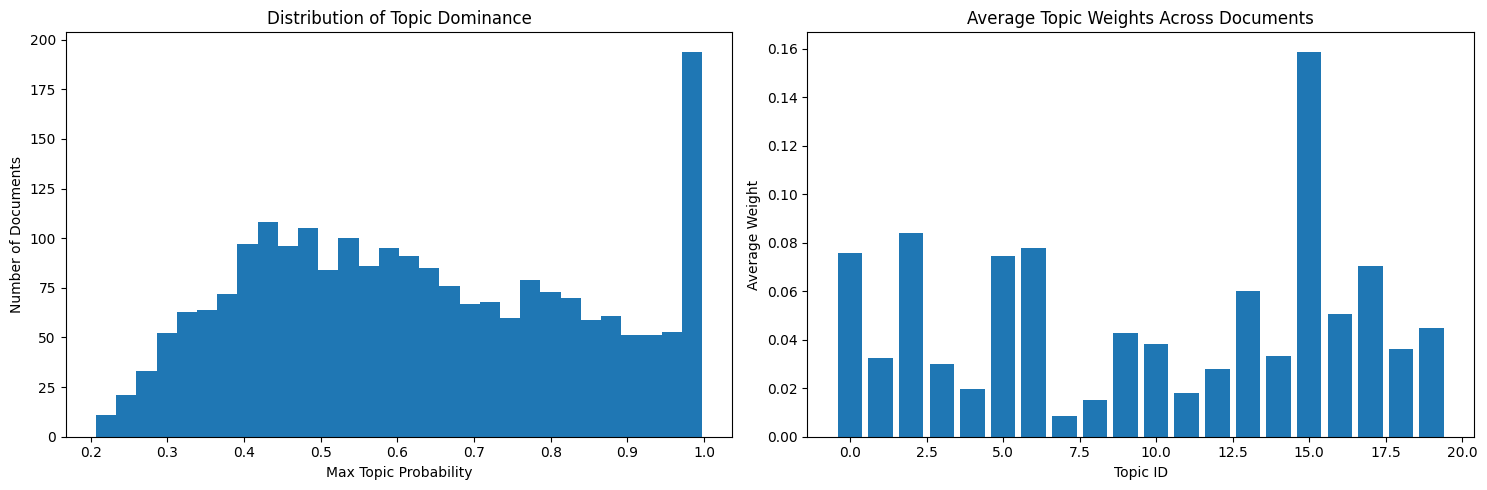

In [5]:
# 토픽 분포 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(doc_topics.max(axis=1), bins=30)
plt.title('Distribution of Topic Dominance')
plt.xlabel('Max Topic Probability')
plt.ylabel('Number of Documents')

plt.subplot(1, 2, 2)
topic_weights = doc_topics.mean(axis=0)
plt.bar(range(n_topics), topic_weights)
plt.title('Average Topic Weights Across Documents')
plt.xlabel('Topic ID')
plt.ylabel('Average Weight')
plt.tight_layout()
plt.show()